In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle

In [3]:
df = pd.read_csv('df_hw.csv')

#### Если магазин офлайн, то мы не можем предлагать покупателям товары по разным ценам одновременно, не можем же мы написать, если у вас карточка с четным айдишником вам дороже, значит нужно менять ценики каждый день, рабиваем выборку на четные и нечетные дни

In [8]:
df[df.day % 2 == 1]

,Unnamed: 0,user_id,metric,day
2,2995,2995,6742.954000,5
3,15885,5885,8998.112105,15
4,6121,6121,2281.206200,1
5,7677,7677,8589.278300,7
6,3539,3539,3959.062100,9
...,...,...,...,...
19991,2455,2455,4327.163100,5
19994,4113,4113,5359.062900,3
19995,14257,4257,6853.369866,17
19997,10317,317,5002.546357,17


#### видим что одинаковое количетсво четных и нечетных дней

### Мощность и корректность

#### A/A test

In [57]:
p_values = []
for _ in range(10000):
    group_A = df[df.day % 2 == 0]['metric'].sample(n = 100).values
    group_B = df[df.day % 2 == 1]['metric'].sample(n = 100).values
    p = scipy.stats.ttest_ind(group_A, group_B).pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < 0.05].shape[0] / p_values.shape[0])

0.0533


(array([1006., 1014., 1051.,  928., 1016.,  990., 1000.,  993.,  988.,
        1014.]),
 array([2.24433234e-04, 1.00201969e-01, 2.00179506e-01, 3.00157042e-01,
        4.00134578e-01, 5.00112114e-01, 6.00089650e-01, 7.00067186e-01,
        8.00044723e-01, 9.00022259e-01, 9.99999795e-01]),
 <a list of 10 Patch objects>)

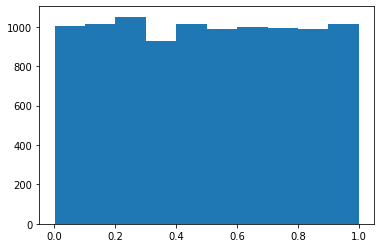

In [58]:
plt.hist(p_values)

##### Критерий применять можно, распределение корректное

### A/B тест на максимум дней с эффектом 2%

In [63]:
p_values = []
for _ in range(10000):
    group_A = df[df.day % 2 == 0]['metric'].sample(n = 100).values
    group_B = df[df.day % 2 == 1]['metric'].sample(n = 100).values*1.02
    p = scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < 0.05].shape[0] / p_values.shape[0])

0.0651


(array([1235., 1121., 1047., 1020.,  977.,  978.,  901.,  929.,  875.,
         917.]),
 array([2.99190679e-05, 1.00022432e-01, 2.00014944e-01, 3.00007457e-01,
        3.99999970e-01, 4.99992483e-01, 5.99984995e-01, 6.99977508e-01,
        7.99970021e-01, 8.99962533e-01, 9.99955046e-01]),
 <a list of 10 Patch objects>)

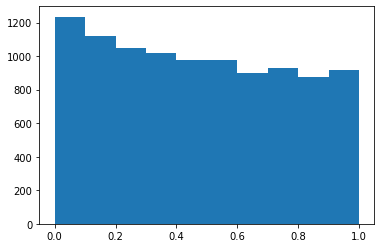

In [64]:
plt.hist(p_values)

#### попробуем другой критерий

0.0619


(array([1161., 1052., 1030.,  994., 1032.,  932.,  965.,  967.,  886.,
         981.]),
 array([5.98843024e-05, 9.99564188e-02, 1.99852953e-01, 2.99749488e-01,
        3.99646022e-01, 4.99542557e-01, 5.99439091e-01, 6.99335626e-01,
        7.99232160e-01, 8.99128695e-01, 9.99025229e-01]),
 <a list of 10 Patch objects>)

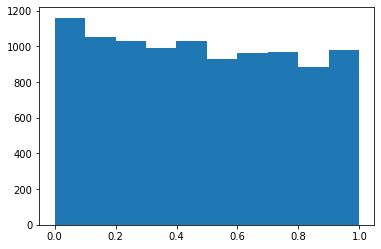

In [82]:
p_values = []
iters = 10000
for _ in range(iters):
    group_A = df[df.day % 2 == 0]['metric'].sample(n = 100).values
    group_B = df[df.day % 2 == 1]['metric'].sample(n = 100).values*1.02
    p = scipy.stats.mannwhitneyu(group_A, group_B,alternative='two-sided').pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < 0.05].shape[0] / p_values.shape[0])
plt.hist(p_values)

#### p_values теперь распределно неравномерно, но критерий сработал  всего в 6,5 процентах случаев, этого явно недостаточно
задетектить 2% не получится

### попробуем задетектить эффект в 22%

0.8513


(array([9148.,  436.,  185.,   89.,   48.,   34.,   17.,   18.,   11.,
          14.]),
 array([6.08981466e-11, 9.98611854e-02, 1.99722371e-01, 2.99583556e-01,
        3.99444741e-01, 4.99305927e-01, 5.99167112e-01, 6.99028297e-01,
        7.98889483e-01, 8.98750668e-01, 9.98611853e-01]),
 <a list of 10 Patch objects>)

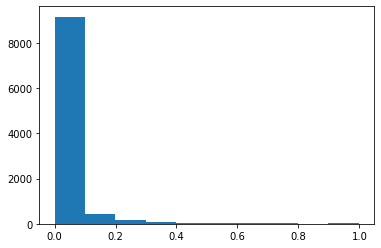

In [78]:
p_values = []
for _ in range(10000):
    group_A = df[df.day % 2 == 0]['metric'].sample(n = 100).values
    group_B = df[df.day % 2 == 1]['metric'].sample(n = 100).values*1.22
    p = scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < 0.05].shape[0] / p_values.shape[0])
plt.hist(p_values)

## 0.9751 больше 0.8 такой эффект задетектить мы можем

### теперь попробуем задетектить эффект при меньшем количестве дней, идем с наименьшего пока не дойдем до значения больше 0.8

0.8454


(array([9.096e+03, 4.690e+02, 1.980e+02, 9.200e+01, 4.800e+01, 2.700e+01,
        3.000e+01, 1.800e+01, 1.800e+01, 4.000e+00]),
 array([2.08547133e-13, 9.89106158e-02, 1.97821232e-01, 2.96731847e-01,
        3.95642463e-01, 4.94553079e-01, 5.93463695e-01, 6.92374310e-01,
        7.91284926e-01, 8.90195542e-01, 9.89106158e-01]),
 <a list of 10 Patch objects>)

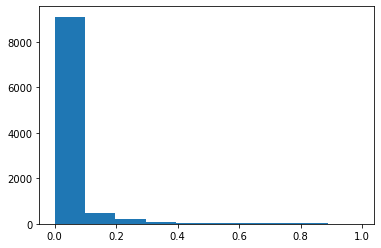

In [81]:
p_values = []
for _ in range(10000):
    _df = df[df.day < 8]
    group_A = _df[_df.day % 2 == 0]['metric'].sample(n = 100).values
    group_B = _df[_df.day % 2 == 1]['metric'].sample(n = 100).values*1.22
    p = scipy.stats.ttest_ind(group_A, group_B, equal_var=False).pvalue
    p_values.append(p)
p_values = np.array(p_values)
print(p_values[p_values < 0.05].shape[0] / p_values.shape[0])
plt.hist(p_values)

#### можно задетектить за 8 дней

#### Задетектить 2% у меня не получилось даже за 20 дней, речи о 3 дней и нет, для более успешного тестирования нужно подбирать более мощные критерии и брать больше данных, возможно я что-то упустил